# Import modules

In [ ]:
import pandas as pd
from src.constants import (
    PREPROCESSING_PATH,
    TARGET
)

import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import power_transform
from catboost import CatBoostRegressor
from utils.classes.extractor import FunctionalGroupToGramExtractor

from typing import (
    Optional,
    List
)
from sklearn.model_selection import KFold

# Load essentials

In [ ]:
Train = pd.read_csv(f"{PREPROCESSING_PATH}/train_merged_CIF/Train.csv")
Train = Train.set_index(Train.columns[0])

Pretest = pd.read_csv(f"{PREPROCESSING_PATH}/pretest_merged_CIF/Pretest.csv")
Pretest = Pretest.set_index(Pretest.columns[0])

funtional_group_extractor = FunctionalGroupToGramExtractor()

# Set up pipeline

## Drop surface area = -1

In [ ]:
# Training set only
def drop_surface_area_equal_minus_1(df):
    return df.drop(df[df['surface_area [m^2/g]'] == -1].index)

## Replace surface area = 0 with np.nan

In [ ]:
def  replace_surface_area_equal_0_with_null(
    df: pd.DataFrame
):
    df['surface_area [m^2/g]'] = df['surface_area [m^2/g]'].replace(0, np.nan)
    return df

## Replace -∞ and ∞ with np.nan

In [ ]:
def replace_inf_with_null(df: pd.DataFrame):
    df = df.replace(np.inf, np.nan)
    df = df.replace(-np.inf, np.nan)
    return df

## Check object columns

In [ ]:
def drop_unused_columns(
    df,
    unused_columns:Optional[List[str]]=None
) -> pd.DataFrame:
    if not unused_columns:
        unused_columns = [
            'MOFname',
            'functional_groups',
            'topology',
            'cif_filepath',
            '_audit_creation_date',
            '_symmetry_space_group_name_H-M',
            '_space_group_crystal_system'
        ]
    for col in unused_columns:
        try:
            df.drop(col, axis=1, inplace=True)
        except KeyError:
            pass
    return df

In [ ]:
def set_imputer(X: pd.DataFrame) -> KNNImputer:
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(X)
    return imputer

def impute_value(X: pd.DataFrame, imputer: KNNImputer):
    return imputer.transform(X)

In [ ]:
def extract_functional_group(
    X: pd.DataFrame,
    fit: bool
)-> pd.DataFrame:
    funtional_group_extacted = funtional_group_extractor.transform(X, fit)
    return pd.concat([X, funtional_group_extractor], axis=1)

# Run pipeline

In [ ]:
Train = drop_surface_area_equal_minus_1(Train)
Train = replace_surface_area_equal_0_with_null(Train)
Train = replace_inf_with_null(Train)
Train = drop_unused_columns(Train)
X = Train.drop(TARGET, axis=1)
y = Train[[TARGET]]

temp_columns = X.columns
temp_index = X.index

imputer = set_imputer(X)
X = impute_value(X, imputer)

X = pd.DataFrame(X)
X.columns = temp_columns
X.index = temp_index

# X = pd.concat([X, element_gram], axis=1)

In [ ]:
Pretest = replace_surface_area_equal_0_with_null(Pretest)
Pretest = replace_inf_with_null(Pretest)
Pretest = drop_unused_columns(Pretest)

# Pretest_functional_group = Pretest[['functional_groups']]
# Pretest = Pretest.drop('functional_groups', axis=1)
temp_columns = Pretest.columns
temp_index = Pretest.index
Pretest = impute_value(Pretest, imputer)


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
Pretest = pd.DataFrame(Pretest)
Pretest.index = temp_index
Pretest.columns = temp_columns

In [ ]:
X 

,volume [A^3],weight [u],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],metal_linker,organic_linker1,organic_linker2,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol],...,_cell_angle_gamma,_cell_volume,partial_charge_mean,partial_charge_median,partial_charge_std,bond_type_countS,bond_type_countA,bond_type_countD,bond_type_countT,bond_type_countAm
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,1116.667429,875.240600,941.764,0.07899,0.0607,3.0,4.0,11.0,22.864166,6.786041,...,90.261935,1116.667429,-1.333333e-08,0.024709,0.561043,56.0,20.0,8.0,0.0,0.0
2,2769.503842,2211.697211,603.610,0.13794,0.1040,10.0,44.0,57.0,33.616780,7.147286,...,96.942210,2769.503842,5.154639e-09,0.059489,0.476006,162.0,50.0,8.0,1.0,0.0
3,1089.818728,773.687960,788.500,0.14874,0.1262,2.0,22.0,24.0,19.263726,6.347967,...,90.387501,1089.818728,-3.658537e-08,0.126583,0.413161,87.0,8.0,2.0,0.0,0.0
4,2205.198301,1304.638720,1441.530,0.21814,0.2220,9.0,17.0,24.0,25.701377,6.190085,...,90.532988,2205.198301,4.464286e-08,-0.016101,0.414075,86.0,54.0,2.0,0.0,0.0
5,1137.800963,901.736120,655.396,0.07778,0.0591,2.0,1.0,22.0,30.001838,6.478063,...,91.404649,1137.800963,-3.191489e-08,0.143280,0.402762,84.0,20.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68609,1188.302573,1001.700216,565.646,0.00000,0.0000,3.0,4.0,24.0,24.131770,7.966631,...,90.753457,1188.302573,3.361345e-08,0.202590,0.441255,113.0,20.0,0.0,0.0,0.0
68610,1506.660363,1493.296496,544.566,0.01108,0.0000,10.0,42.0,46.0,6.071818,8.067713,...,97.430499,1506.660363,-5.555556e-08,0.028650,0.426625,113.0,23.0,10.0,0.0,0.0
68611,2035.532738,1959.518320,301.876,0.00000,0.0000,4.0,14.0,22.0,9.876134,9.995719,...,59.292454,2035.532738,2.450980e-08,0.075630,0.332719,153.0,79.0,0.0,0.0,0.0


In [ ]:
def log_mean_absolute_error(y_true, y_pred):
    return np.log(mean_absolute_error(y_true, y_pred))


def fit_catboost(X, y):
    catboost = CatBoostRegressor(iterations=1000, verbose=False)
    catboost.fit(X, y)
    return catboost

def fit_catboost(X, y):
    catboost = CatBoostRegressor(iterations=1000, verbose=False)
    catboost.fit(X, y)
    return catboost

fit_models = [fit_catboost]
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

fit_results = {}
for k, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"K Fold: {k + 1}")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for fit_model in fit_models:
        model_name = '_'.join(fit_model.__name__.split('fit_')[1:])
        if model_name not in fit_results:
            fit_results[model_name] = []

        model = fit_model(X_train, y_train)
        train_pred = model.predict(X_train)
        log_mean_error_train = log_mean_absolute_error(y_train, train_pred)

        model = fit_model(X_test, y_test)
        test_pred = model.predict(X_test)
        log_mean_error_test = log_mean_absolute_error(y_test, test_pred)
        print(f"Log mean error train: {log_mean_error_train}")
        print(f"Log mean error test: {log_mean_error_test}")

        fit_results[model_name].append({
            'model': model,
            'log_mean_error_train': log_mean_error_train,
            'log_mean_error_test': log_mean_error_test
        })

K Fold: 1
TRAIN: [    1     2     3 ... 68551 68552 68556] TEST: [    0     4    13 ... 68553 68554 68555]
Log mean error train: 2.854255645759708
Log mean error test: 2.717562476787219
K Fold: 2
TRAIN: [    0     1     2 ... 68554 68555 68556] TEST: [   24    32    37 ... 68535 68536 68545]
Log mean error train: 2.8512157347168374
Log mean error test: 2.711303907019775
K Fold: 3
TRAIN: [    0     1     3 ... 68553 68554 68555] TEST: [    2     8     9 ... 68538 68548 68556]
Log mean error train: 2.8546759761583433
Log mean error test: 2.7087070515726177
K Fold: 4
TRAIN: [    0     2     3 ... 68554 68555 68556] TEST: [    1     5     6 ... 68547 68551 68552]
Log mean error train: 2.8464327645129197
Log mean error test: 2.7346996775561636
K Fold: 5
TRAIN: [    0     1     2 ... 68554 68555 68556] TEST: [    3    10    16 ... 68543 68544 68549]
Log mean error train: 2.844976102605712
Log mean error test: 2.7331464830336327


In [ ]:
# train_prediction = .predict(X)

In [ ]:
# np.log(mean_absolute_error(train_prediction, y))

2.8635058694956403

In [ ]:
# feature_importances = pd.DataFrame(catboost.feature_importances_)
# feature_importances.index = Train.drop(TARGET, axis=1).columns

In [ ]:
# feature_importances.sort_values(by=0, ascending=False)

,0
CO2/N2_selectivity,35.937773
void_volume [cm^3/g],16.560836
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol],15.907282
surface_area [m^2/g],4.884843
weight [u],2.992961
...,...
_symmetry_Int_Tables_number,0.000000
functional_group_bigram_Me-C,0.000000
functional_group_bigram_C-N,0.000000
functional_group_bigram_H-F,0.000000


<AxesSubplot:>

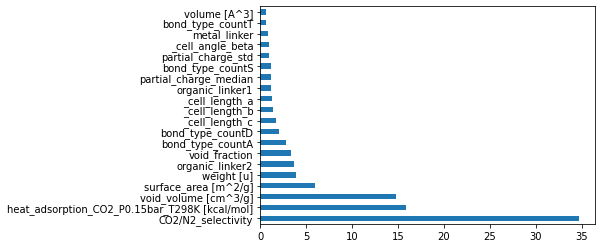

In [ ]:
# feature_importances[0].nlargest(20).plot(kind='barh')

In [ ]:
# feature_importances[0].nlargest(20).index

Index(['CO2/N2_selectivity', 'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]',
       'void_volume [cm^3/g]', 'surface_area [m^2/g]', 'weight [u]',
       'organic_linker2', 'void_fraction', 'bond_type_countA',
       'bond_type_countD', '_cell_length_c', '_cell_length_b',
       '_cell_length_a', 'organic_linker1', 'partial_charge_median',
       'bond_type_countS', 'partial_charge_std', '_cell_angle_beta',
       'metal_linker', 'bond_type_countT', 'volume [A^3]'],
      dtype='object')

In [ ]:
sub = np.mean([model['model'].predict(Pretest) for model in fit_results['catboost']], axis=0)

In [ ]:
sub = pd.DataFrame(sub)

In [ ]:
Pretest = pd.read_csv(f"{PREPROCESSING_PATH}/pretest_merged_CIF/Pretest.csv")
# Pretest = Pretest.set_index(Pretest.columns[0])
sub.index = "pretest_" + pd.Index(range(1, sub.shape[0] + 1)).astype(str)
sub.index = sub.index.set_names('id')
sub.columns = ['CO2_working_capacity [mL/g]']

In [ ]:
sub

,CO2_working_capacity [mL/g]
id,
pretest_1,98.606887
pretest_2,127.483830
pretest_3,189.176967
pretest_4,67.609159
pretest_5,94.117071
...,...
pretest_1996,-1.787666
pretest_1997,16.246297
pretest_1998,4.231077


In [ ]:
sub.to_csv("submission.csv")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf8541de-dbc3-45f6-bc1e-4fa446cacbcd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>